In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem.Fraggle import FraggleSim
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import rdDepictor
from rdkit import RDConfig
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Geometry import Point3D
from rdkit.Chem import rdForceFieldHelpers
from random import randrange
import py3Dmol

#from rdkit import rdBase
#rdBase.DisableLog('rdApp.error')
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import xyz2mol as x2m
import PBA_mutation as PBA_mu
import os

from DBA_mututation import PBA_mutation
import DBA_GA_utils

import crossover as co
co.average_size = 40
co.size_stdev = 4.0

charged_fragments = True
quick = True

def drawit(ms, p=None, confId=-1, removeHs=True,colors=('cyanCarbon','redCarbon','blueCarbon')):
        if p is None:
            p = py3Dmol.view(width=600, height=600)
        p.removeAllModels()
        for i,m in enumerate(ms):
            if removeHs:
                m = Chem.RemoveHs(m)
            IPythonConsole.addMolToView(m,p,confId=confId)
            p.setStyle({'model':-1,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

def show_3dmol(image_id=None,inchi=None,smiles=None,mol=None):
    mol = mol
    if not mol:
        print('No molecule is provided')
        return
           
    molh = Chem.AddHs(mol)
    #if AllChem.EmbedMolecule(molh,randomSeed=0xf00d)<0:
    #    print('Failed to embed in 3d')
    #    return
    pdb_data = Chem.MolToPDBBlock(molh)
    view = py3Dmol.view(width=600, height=600, query=None, data=pdb_data, linked=False)
    view.setStyle({'model':-1,},{'stick': {}})
    #view.setBackgroundColor('#f9f4fb')
    return view

# Reading Initial Population

In [7]:
###################################################################
"""
Function to read the list file with of the complex, creating two arrays, one for the free ligand and the other for the
free ligand
"""
dir = os.getcwd()
#xyzfiles = os.listdir('data_cmplxs/')
#xyzfiles = os.listdir('m-Glc_Frc-m/')
xyzfiles = os.listdir('linkers2classify')
linkers = []
cores = []
cores_xyz = []
names = []
cmplxs = []
cmplxs_xyz = []
Num_atoms = []
for xyzfile in xyzfiles:
    #file = "data_cmplxs/" + xyzfile
    #file = "m-Glc_Frc-m/" + xyzfile
    file = "linkers2classify/" + xyzfile
    #print("New Liker:",xyzfile)
    names.append(str(xyzfile))
    atoms, charge_read, coordinates = x2m.read_xyz_file(file)
    chrg = -2
    if xyzfile == 'cmplx113.xyz':
        chrg = 0
    elif xyzfile == 'cmplx114.xyz':
        chrg = -1
    raw_mol = x2m.xyz2mol(atoms, coordinates, charge=chrg)
    Chem.SanitizeMol(raw_mol[0])

    #new_core, new_linkHs = core_linker_frag(Chem.MolFromSmiles(Chem.MolToSmiles(raw_mol[0])),False)
    new_core, new_linkHs, core_xyz = DBA_GA_utils.core_linker_frag(raw_mol[0],coordinates)
    new_link = Chem.RemoveHs(new_linkHs)

    new_link.SetProp('pKaglcyl',str(8.8))
    new_link.SetProp('pKafrcyl',str(8.8))
    
    #linkers.append(Chem.MolFromSmiles(Chem.MolToSmiles(new_link)))
    linkers.append(new_link)
    cores.append(new_core)
    cores_xyz.append(core_xyz)
    cmplxs.append(raw_mol[0])
    cmplxs_xyz.append(coordinates)
    Num_atoms.append(new_link.GetNumAtoms())
    
print('Linkers avg atoms=',sum(Num_atoms)/len(Num_atoms))
print('Linkers min atoms=',min(Num_atoms))
print('Linkers max atoms=',max(Num_atoms))
#print(Chem.MolToMolBlock(new_core))
#print(Chem.MolToMolBlock(new_core),file=open('Sucrose_core.mol','w+'))

Linkers avg atoms= 25.801980198019802
Linkers min atoms= 22
Linkers max atoms= 36


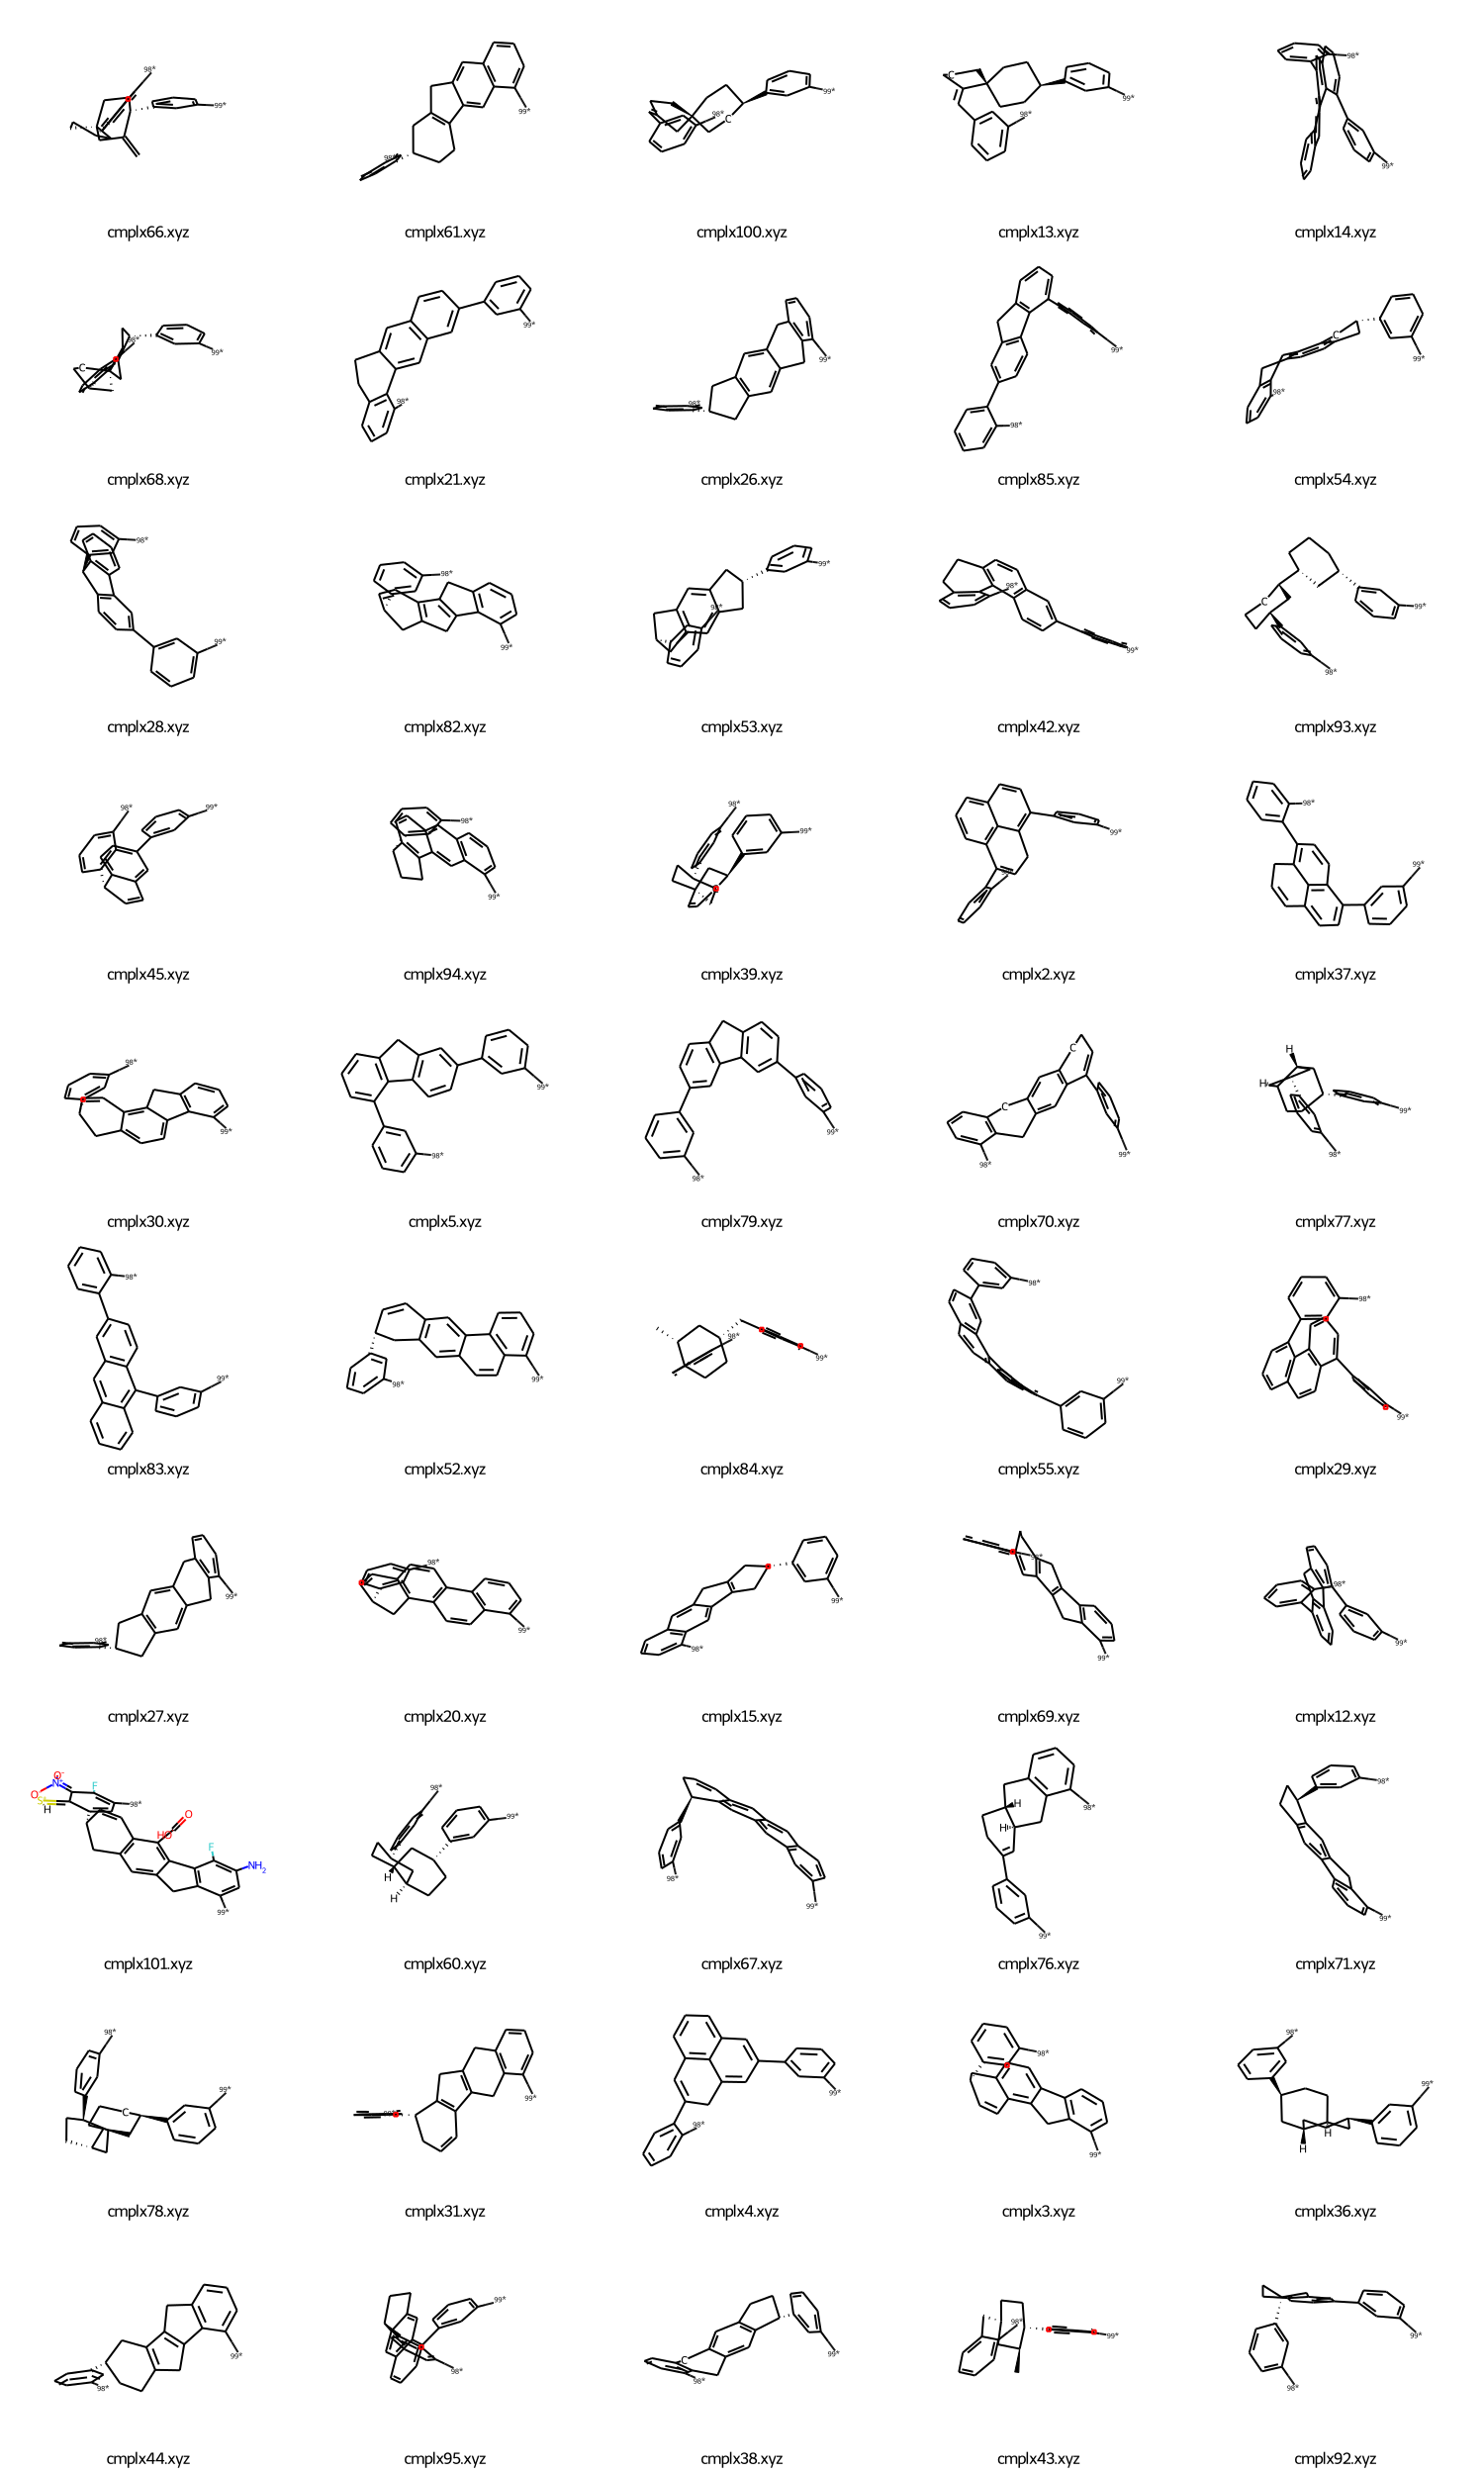

In [3]:
Draw.MolsToGridImage(linkers, molsPerRow=5, subImgSize=(300,250), legends=names)#, returnPNG=True)

# Mutation Operation

Linker parent: [98*]C1=CC=CC([C@H]2CC=CC3=C2CC2=C3CC3=C(C=CC=C3[99*])C2)=C1
Linker child: [98*]C1=C([C@H]2CC=CC3=C2CC2=C3CC3=C([99*])C=CC=C3C2)C=CN=C1F


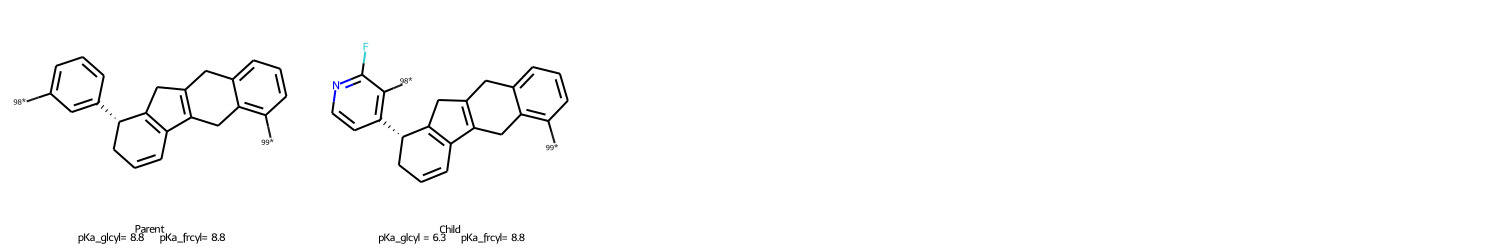

In [4]:
mols = []
rnd_idx = randrange(len(linkers))
#print(len(linkers))
#print(rnd_idx)
#rnd_idx = 10
linker = linkers[rnd_idx]
mols.append(Chem.MolFromSmiles(Chem.MolToSmiles(linker)))
suc_core = cores[rnd_idx]
suc_core_xyz = cores_xyz[rnd_idx]
cmplx_parent = cmplxs[rnd_idx]
cmplx_parent_xyz = cmplxs_xyz[rnd_idx]
#linker_nHs = Chem.RemoveHs(linker)
#Chem.SanitizeMol(linker)
print('Linker parent:',Chem.MolToSmiles(linker,kekuleSmiles=True))

# The operations for mutation should be performed inside the mutation.py file
## Glcosyl side

idx_glcyl, glcylpatt = DBA_GA_utils.tweezer_classification(linker,'Glc')
idx_frcyl, frcylpatt = DBA_GA_utils.tweezer_classification(linker,'Frc')

linker_child = PBA_mutation(linker,idx_glcyl,glcylpatt,idx_frcyl,frcylpatt)
print('Linker child:',Chem.MolToSmiles(linker_child,kekuleSmiles=True))
mols.append(Chem.MolFromSmiles(Chem.MolToSmiles(linker_child)))
#Chem.MolFromSmiles(Chem.MolToSmiles(linker_child))
names = ['Parent\n pKa_glcyl= %s \t pKa_frcyl= %s' %(linker.GetProp('pKaglcyl'),linker.GetProp('pKafrcyl')), \
         'Child\n pKa_glcyl = %s \t pKa_frcyl= %s' %(linker_child.GetProp('pKaglcyl'),linker_child.GetProp('pKafrcyl'))]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,250), legends=names, useSVG=True)

In [5]:
#Function bonding the new linker to the core
linker_child.UpdatePropertyCache(strict=False)
Chem.SanitizeMol(linker_child)
cmplx_mut = DBA_GA_utils.linker_core_bonding(suc_core, linker_child)
cmplx_mut.UpdatePropertyCache(strict=False)
cmplxh_mut = Chem.AddHs(cmplx_mut, addCoords=True)
cmplxh_parent = Chem.AddHs(cmplx_parent, addCoords=True)
Chem.SanitizeMol(cmplxh_mut)
Chem.SanitizeMol(cmplxh_parent)

#cmplx_parent_xyz coordinates of the parent complex 
#suc_core_xyz coordinates of the selected core
#suc_core is selected from cores array 

suc_core_4patt = Chem.RWMol(suc_core)
suc_core_4patt.BeginBatchEdit()
for atom in suc_core_4patt.GetAtoms():
    #print(atom.GetIdx(),atom.GetAtomicNum())
    if atom.GetAtomicNum() == 0:
        #print('Print dummy atom',atom.GetIdx())
        suc_core_4patt.RemoveAtom(atom.GetIdx())
suc_core_4patt.CommitBatchEdit()
Chem.SanitizeMol(suc_core_4patt)
suc_core_mol = suc_core_4patt.GetMol()

#AllChem.EmbedMolecule(cmplxh_mut)
AllChem.EmbedMolecule(cmplxh_parent)

for i in range(cmplxh_parent.GetNumAtoms()):
    x,y,z = cmplx_parent_xyz[i]
    cmplxh_parent.GetConformer().SetAtomPosition(i,Point3D(x,y,z))

match_child = cmplxh_mut.GetSubstructMatch(suc_core_mol)
match_parent = cmplxh_parent.GetSubstructMatch(suc_core_mol)
#print(match_child)
#print(match_parent)

#AllChem.AlignMol(cmplxh_mut,cmplxh_parent,atomMap = list(zip(match_child,match_parent)))
#AllChem.AlignMol(cmplxh_mut,cmplxh_parent)

cmap = {match_child[i]:cmplxh_parent.GetConformer().GetAtomPosition(match_parent[i]) for i in range(len(match_parent))}
if AllChem.EmbedMolecule(cmplxh_mut,randomSeed=0xf00d,coordMap=cmap,useRandomCoords=True) < 0:
    AllChem.EmbedMolecule(cmplxh_mut,useRandomCoords=True) # Here set the condition to return the Mol or None
#print('Complex mut:',Chem.MolToSmiles(cmplxh_mut,kekuleSmiles=True))

#print('Coordinates parent')
#print(cmplxh_parent.GetNumAtoms())
#print()
#for i, atom in enumerate(cmplxh_parent.GetAtoms()):
#    positions = cmplxh_parent.GetConformer().GetAtomPosition(i)
#    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

#print('Coordinates child')
#print(cmplxh_mut.GetNumAtoms())
#print()
#for i, atom in enumerate(cmplxh_mut.GetAtoms()):
#    positions = cmplxh_mut.GetConformer().GetAtomPosition(i)
#    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

mcp = Chem.Mol(cmplxh_mut)
ff = rdForceFieldHelpers.UFFGetMoleculeForceField(mcp)
for atidx in match_child:
    #print('atidx:',atidx)
    ff.UFFAddPositionConstraint(atidx,0.05,200)
maxIters = 10
while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -= 1

#print('Coordinates child UFF optimization')
#print(mcp.GetNumAtoms())
#print()
#for i, atom in enumerate(mcp.GetAtoms()):
#    positions = mcp.GetConformer().GetAtomPosition(i)
#    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 
drawit((cmplxh_mut,cmplxh_parent),removeHs=False)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Crossover operation

Parent A: [98*]C1=CC=CC([C@@H]2CC[C@]3(CC[C@H](C4=CC([99*])=CC=C4)C(=C)C3)C2)=C1
Parent B: [98*]C1=CC=CC=C1[C@@H]1CC[C@@]2(C=C(C3=CC([99*])=CC=C3)CC2)C1
Linker temp child: [98*]c1ccccc1[C@@H]1C=CC[C@]2(CC[C@H](c3cccc([99*])c3)C(=C)C2)C1
Linker child: [98*]c1ccc([C@@H]2C=CC[C@]3(CC[C@@H](c4cccc([99*])c4)C(=C)C3)C2)cc1


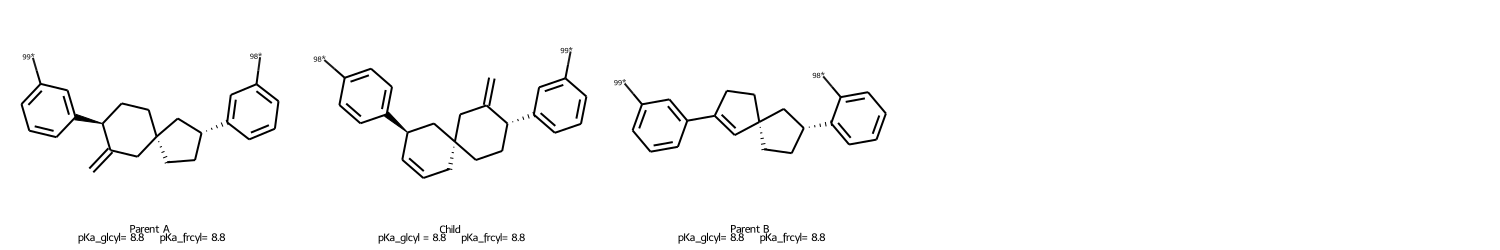

In [6]:
mols = []
linker_child = None
while linker_child == None:
    rnd_idx_A = randrange(len(linkers))
    suc_core_A = cores[rnd_idx_A]
    parent_A = linkers[rnd_idx_A]
    rnd_idx_B = randrange(len(linkers))
    suc_core_B = cores[rnd_idx_B]
    parent_B = linkers[rnd_idx_B]
    linker_temp = co.crossover(parent_A,parent_B)
    if co.mol_OK(linker_temp) and DBA_GA_utils.linker_crossover_OK(linker_temp):
        idx_glcyl, glcylpatt = DBA_GA_utils.tweezer_classification(linker_temp,'Glc')
        idx_frcyl, frcylpatt = DBA_GA_utils.tweezer_classification(linker_temp,'Frc')
        linker_child = PBA_mutation(linker_temp,idx_glcyl,glcylpatt,idx_frcyl,frcylpatt)
        suc_core = cores[rnd_idx_A]
        suc_core_xyz = cores_xyz[rnd_idx_A]
        cmplx_parent = cmplxs[rnd_idx_A]
        cmplx_parent_xyz = cmplxs_xyz[rnd_idx_A]

mols.append(Chem.MolFromSmiles(Chem.MolToSmiles(parent_A)))
mols.append(Chem.MolFromSmiles(Chem.MolToSmiles(linker_child)))
mols.append(Chem.MolFromSmiles(Chem.MolToSmiles(parent_B)))
print('Parent A:',Chem.MolToSmiles(parent_A,kekuleSmiles=False))
print('Parent B:',Chem.MolToSmiles(parent_B,kekuleSmiles=False))
print('Linker temp child:',Chem.MolToSmiles(linker_temp,kekuleSmiles=False))
print('Linker child:',Chem.MolToSmiles(linker_child,kekuleSmiles=False))
#print('pKa_glcyl =',linker_child.GetProp('pKaglcyl'))
#print('pKa_frcyl =',linker_child.GetProp('pKafrcyl'))
names = ['Parent A\n pKa_glcyl= %s \t pKa_frcyl= %s' %(parent_A.GetProp('pKaglcyl'),parent_A.GetProp('pKafrcyl')), \
         'Child\n pKa_glcyl = %s \t pKa_frcyl= %s' %(linker_child.GetProp('pKaglcyl'),linker_child.GetProp('pKafrcyl')), \
         'Parent B\n pKa_glcyl= %s \t pKa_frcyl= %s' %(parent_B.GetProp('pKaglcyl'),parent_B.GetProp('pKafrcyl'))]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,250), legends=names, useSVG=True)

In [7]:
print('Parent A:',Chem.MolToSmiles(parent_A,kekuleSmiles=False))
print('Parent B:',Chem.MolToSmiles(parent_B,kekuleSmiles=False))
print('Linker temp child:',Chem.MolToSmiles(linker_temp,kekuleSmiles=False))
print('Linker child:',Chem.MolToSmiles(linker_child,kekuleSmiles=False)) 

Parent A: [98*]C1=CC=CC([C@@H]2CC[C@]3(CC[C@H](C4=CC([99*])=CC=C4)C(=C)C3)C2)=C1
Parent B: [98*]C1=CC=CC=C1[C@@H]1CC[C@@]2(C=C(C3=CC([99*])=CC=C3)CC2)C1
Linker temp child: [98*]c1ccccc1[C@@H]1C=CC[C@]2(CC[C@H](c3cccc([99*])c3)C(=C)C2)C1
Linker child: [98*]c1ccc([C@@H]2C=CC[C@]3(CC[C@@H](c4cccc([99*])c4)C(=C)C3)C2)cc1


In [8]:
#Function bonding the new linker to the core
linker_child.UpdatePropertyCache(strict=False)
Chem.SanitizeMol(linker_child)
cmplx_mut = DBA_GA_utils.linker_core_bonding(suc_core, linker_child)
cmplx_mut.UpdatePropertyCache(strict=False)
cmplxh_mut = Chem.AddHs(cmplx_mut, addCoords=True)
cmplxh_parent = Chem.AddHs(cmplx_parent, addCoords=True)
Chem.SanitizeMol(cmplxh_mut)
Chem.SanitizeMol(cmplxh_parent)

#cmplx_parent_xyz coordinates of the parent complex 
#suc_core_xyz coordinates of the selected core
#suc_core is selected from cores array 

suc_core_4patt = Chem.RWMol(suc_core)
suc_core_4patt.BeginBatchEdit()
for atom in suc_core_4patt.GetAtoms():
    #print(atom.GetIdx(),atom.GetAtomicNum())
    if atom.GetAtomicNum() == 0:
        #print('Print dummy atom',atom.GetIdx())
        suc_core_4patt.RemoveAtom(atom.GetIdx())
suc_core_4patt.CommitBatchEdit()
Chem.SanitizeMol(suc_core_4patt)
suc_core_mol = suc_core_4patt.GetMol()

#AllChem.EmbedMolecule(cmplxh_mut)
AllChem.EmbedMolecule(cmplxh_parent)

for i in range(cmplxh_parent.GetNumAtoms()):
    x,y,z = cmplx_parent_xyz[i]
    cmplxh_parent.GetConformer().SetAtomPosition(i,Point3D(x,y,z))

match_child = cmplxh_mut.GetSubstructMatch(suc_core_mol)
match_parent = cmplxh_parent.GetSubstructMatch(suc_core_mol)
#print(match_child)
#print(match_parent)

#AllChem.AlignMol(cmplxh_mut,cmplxh_parent,atomMap = list(zip(match_child,match_parent)))
#AllChem.AlignMol(cmplxh_mut,cmplxh_parent)

cmap = {match_child[i]:cmplxh_parent.GetConformer().GetAtomPosition(match_parent[i]) for i in range(len(match_parent))}
if AllChem.EmbedMolecule(cmplxh_mut,randomSeed=0xf00d,coordMap=cmap,useRandomCoords=True) < 0:
    AllChem.EmbedMolecule(cmplxh_mut,useRandomCoords=True) # Here set the condition to return the Mol or None
#print('Complex mut:',Chem.MolToSmiles(cmplxh_mut,kekuleSmiles=True))

#print('Coordinates parent')
#print(cmplxh_parent.GetNumAtoms())
#print()
#for i, atom in enumerate(cmplxh_parent.GetAtoms()):
#    positions = cmplxh_parent.GetConformer().GetAtomPosition(i)
#    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

#print('Coordinates child')
#print(cmplxh_mut.GetNumAtoms())
#print()
#for i, atom in enumerate(cmplxh_mut.GetAtoms()):
#    positions = cmplxh_mut.GetConformer().GetAtomPosition(i)
#    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

mcp = Chem.Mol(cmplxh_mut)
ff = rdForceFieldHelpers.UFFGetMoleculeForceField(mcp)
for atidx in match_child:
    #print('atidx:',atidx)
    ff.UFFAddPositionConstraint(atidx,0.05,200)
maxIters = 10
while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -= 1

#print('Coordinates child UFF optimization')
#print(mcp.GetNumAtoms())
#print()
#for i, atom in enumerate(mcp.GetAtoms()):
#    positions = mcp.GetConformer().GetAtomPosition(i)
#    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 
show_3dmol(mol=mcp)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
import networkx as nx
# Get adjacency matrix
adjacency_matrix = Chem.GetAdjacencyMatrix(mcp, useBO = True)
print(adjacency_matrix)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


0 (2, 4, 6, 10, 9, 12, 11, 7)
(1, (17, 19, 20, 22, 25, 24, 23, 21))


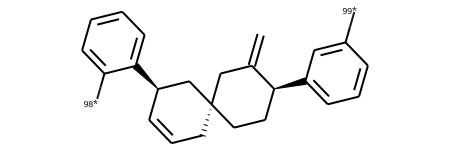

In [10]:
#idx_glcyl, glcylpatt = DBA_GA_utils.tweezer_classification(child_linker,'Glc')
#idx_frcyl, frcylpatt = DBA_GA_utils.tweezer_classification(child_linker,'Frc')
print(idx_glcyl, glcylpatt)
print(DBA_GA_utils.tweezer_classification(linker_temp,'Frc'))
Chem.MolFromSmiles(Chem.MolToSmiles(linker_temp))

In [11]:
#Function bonding the new linker to the core
linker_child.UpdatePropertyCache(strict=False)
Chem.SanitizeMol(linker_child)
cmplx_mut = DBA_GA_utils.linker_core_bonding(suc_core, linker_child)
cmplx_mut.UpdatePropertyCache(strict=False)
cmplxh_mut = Chem.AddHs(cmplx_mut, addCoords=True)
cmplxh_parent = Chem.AddHs(cmplx_parent, addCoords=True)
Chem.SanitizeMol(cmplxh_mut)
Chem.SanitizeMol(cmplxh_parent)

#cmplx_parent_xyz coordinates of the parent complex 
#suc_core_xyz coordinates of the selected core
#suc_core is selected from cores array 

suc_core_4patt = Chem.RWMol(suc_core)
suc_core_4patt.BeginBatchEdit()
for atom in suc_core_4patt.GetAtoms():
    #print(atom.GetIdx(),atom.GetAtomicNum())
    if atom.GetAtomicNum() == 0:
        #print('Print dummy atom',atom.GetIdx())
        suc_core_4patt.RemoveAtom(atom.GetIdx())
suc_core_4patt.CommitBatchEdit()
Chem.SanitizeMol(suc_core_4patt)
suc_core_mol = suc_core_4patt.GetMol()

#AllChem.EmbedMolecule(cmplxh_mut)
AllChem.EmbedMolecule(cmplxh_parent)

for i in range(cmplxh_parent.GetNumAtoms()):
    x,y,z = cmplx_parent_xyz[i]
    cmplxh_parent.GetConformer().SetAtomPosition(i,Point3D(x,y,z))

match_child = cmplxh_mut.GetSubstructMatch(suc_core_mol)
match_parent = cmplxh_parent.GetSubstructMatch(suc_core_mol)
#print(match_child)
#print(match_parent)

#AllChem.AlignMol(cmplxh_mut,cmplxh_parent,atomMap = list(zip(match_child,match_parent)))
#AllChem.AlignMol(cmplxh_mut,cmplxh_parent)

cmap = {match_child[i]:cmplxh_parent.GetConformer().GetAtomPosition(match_parent[i]) for i in range(len(match_parent))}
AllChem.EmbedMolecule(cmplxh_mut,randomSeed=0xf00d,coordMap=cmap,useRandomCoords=True)
print('Complex mut:',Chem.MolToSmiles(cmplxh_mut,kekuleSmiles=True))


print('Coordinates parent')
print(cmplxh_parent.GetNumAtoms())
print()
for i, atom in enumerate(cmplxh_parent.GetAtoms()):
    positions = cmplxh_parent.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

print('Coordinates child')
print(cmplxh_mut.GetNumAtoms())
print()
for i, atom in enumerate(cmplxh_mut.GetAtoms()):
    positions = cmplxh_mut.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

mcp = Chem.Mol(cmplxh_mut)
#mmffps = rdForceFieldHelpers.UFFGetMoleculeProperties(mcp)
ff = rdForceFieldHelpers.UFFGetMoleculeForceField(mcp)
for atidx in match_child:
    #print('atidx:',atidx)
    ff.UFFAddPositionConstraint(atidx,0.05,200)
maxIters = 10
while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -= 1

print('Coordinates child UFF optimization')
print(mcp.GetNumAtoms())
print()
for i, atom in enumerate(mcp.GetAtoms()):
    positions = mcp.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 
    
#I should check the structural integrity of the ligands after the optimization.

Complex mut: [H]O[B@-]12OC([H])([H])[C@@]3([H])O[C@]([H])(O[C@]45O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@]4([H])O[B@@-](O[H])(OC5([H])[H])C4=C([H])C([H])=C([H])C(=C4[H])[C@@]4([H])C(=C([H])[H])C([H])([H])[C@@]5(C([H])([H])C([H])=C([H])[C@@]([H])(C6=C([H])C([H])=C1C([H])=C6[H])C5([H])[H])C([H])([H])C4([H])[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]3([H])O2
Coordinates parent
94

O -2.40548 3.46511 0.11753
C -1.20226 3.01486 0.70482
O -0.15941 3.01476 -0.22224
C -0.07309 1.71698 -0.83803
C 0.04451 1.85553 -2.34085
O -1.08409 2.40266 -2.9673
C -1.26634 0.90617 -0.30984
O -0.92612 -0.45701 -0.31289
C -1.40109 1.5478 1.06227
O -2.53332 1.33898 1.81908
C -0.92855 3.76073 2.00096
O -2.03735 3.53505 2.83248
C -2.48421 4.77307 -0.3736
C -3.66723 5.48588 0.3108
C -4.98661 4.86273 -0.13377
C -5.04021 4.89334 -1.65312
C -3.83274 4.1697 -2.22983
C -3.91322 4.25322 -3.74613
O -5.09545 3.64912 -4.16974
O -2.62268 4.76054 -1.76863
O -6.21816 4.30817 -2.09929
O -6.05229 5.58973 0.43585
O -3.51216 5.5

In [12]:
print('Complex mut:',Chem.MolToSmiles(cmplxh_mut,kekuleSmiles=True))
print('Complex mut:',Chem.MolToSmiles(cmplx_mut,kekuleSmiles=True))
AllChem.EmbedMolecule(cmplxh_mut,useRandomCoords=True)
print('Coordinates child')
print(cmplxh_mut.GetNumAtoms())
print()
for i, atom in enumerate(cmplxh_mut.GetAtoms()):
    positions = cmplxh_mut.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

Complex mut: [H]O[B@-]12OC([H])([H])[C@@]3([H])O[C@]([H])(O[C@]45O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@]4([H])O[B@@-](O[H])(OC5([H])[H])C4=C([H])C([H])=C([H])C(=C4[H])[C@@]4([H])C(=C([H])[H])C([H])([H])[C@@]5(C([H])([H])C([H])=C([H])[C@@]([H])(C6=C([H])C([H])=C1C([H])=C6[H])C5([H])[H])C([H])([H])C4([H])[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]3([H])O2
Complex mut: [H]O[B@@-]12OC([H])([H])[C@]3(O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@]3([H])O1)O[C@@]1([H])O[C@]3([H])C([H])([H])O[B@-](O[H])(O[C@@]3([H])[C@]([H])(O[H])[C@@]1([H])O[H])C1=CC=C(C=C1)[C@@H]1C=CC[C@]3(CC[C@H](C(=C)C3)C3=CC2=CC=C3)C1
Coordinates child
95

O -2.704281896714787 1.5304280198996585 -2.26643421977861
C -2.2709338553841585 2.503588496941324 -1.4186691345624012
O -3.3868853148789104 3.2549814365892304 -1.059195878615717
C -3.778936270308287 3.9416064181224613 -2.2167169952867147
C -4.938113509687766 3.3141937572659685 -2.913641269642504
O -6.022156577590563 3.288302530896381 -2.044505741285235
C -2.5366495

In [13]:
def complex_conformer_generation(linker_child,suc_core,cmplx_parent,cmplx_parent_xyz):
    linker_child.UpdatePropertyCache(strict=False)
    Chem.SanitizeMol(linker_child)
    cmplx_mut = DBA_GA_utils.linker_core_bonding(suc_core, linker_child)
    cmplx_mut.UpdatePropertyCache(strict=False)
    cmplxh_mut = Chem.AddHs(cmplx_mut, addCoords=True)
    cmplxh_parent = Chem.AddHs(cmplx_parent, addCoords=True)
    Chem.SanitizeMol(cmplxh_mut)
    Chem.SanitizeMol(cmplxh_parent)

    suc_core_4patt = Chem.RWMol(suc_core)
    suc_core_4patt.BeginBatchEdit()
    for atom in suc_core_4patt.GetAtoms():
        #print(atom.GetIdx(),atom.GetAtomicNum())
        if atom.GetAtomicNum() == 0:
            #print('Print dummy atom',atom.GetIdx())
            suc_core_4patt.RemoveAtom(atom.GetIdx())
    suc_core_4patt.CommitBatchEdit()
    Chem.SanitizeMol(suc_core_4patt)
    suc_core_mol = suc_core_4patt.GetMol()

    AllChem.EmbedMolecule(cmplxh_parent)

    for i in range(cmplxh_parent.GetNumAtoms()):
        x,y,z = cmplx_parent_xyz[i]
        cmplxh_parent.GetConformer().SetAtomPosition(i,Point3D(x,y,z))

    match_child = cmplxh_mut.GetSubstructMatch(suc_core_mol)
    match_parent = cmplxh_parent.GetSubstructMatch(suc_core_mol)

    cmap = {match_child[i]:cmplxh_parent.GetConformer().GetAtomPosition(match_parent[i]) for i in range(len(match_parent))}
    
    if AllChem.EmbedMolecule(cmplxh_mut,randomSeed=0xf00d,coordMap=cmap,useRandomCoords=True) > -1:
        #mcp = Chem.Mol(cmplxh_mut)
        #ff = rdForceFieldHelpers.UFFGetMoleculeForceField(mcp)
        ff = rdForceFieldHelpers.UFFGetMoleculeForceField(cmplxh_mut)
        for atidx in match_child:
            #print('atidx:',atidx)
            ff.UFFAddPositionConstraint(atidx,0.05,200)
        maxIters = 10
        while ff.Minimize(maxIts=1000) and maxIters>0:
            maxIters -= 1
        cmplxh_mut.SetProp('pKaglcyl',str(linker_child.GetProp('pKaglcyl')))
        cmplxh_mut.SetProp('pKafrcyl',str(linker_child.GetProp('pKafrcyl')))
        return cmplxh_mut
    elif AllChem.EmbedMolecule(cmplxh_mut,useRandomCoords=True) > -1:
        mcp = Chem.Mol(cmplxh_mut)
        cmplxh_mut.SetProp('pKaglcyl',str(linker_child.GetProp('pKaglcyl')))
        cmplxh_mut.SetProp('pKafrcyl',str(linker_child.GetProp('pKafrcyl')))
        return cmplxh_mut
    else:
        return None

In [14]:
def mutation(linkers,cores,cmplxs,cmplxs_xyz):
    for i in range(20):
        rnd_idx = randrange(len(linkers))
        linker = linkers[rnd_idx]
        suc_core = cores[rnd_idx]
        suc_core_xyz = cores_xyz[rnd_idx]
        cmplx_parent = cmplxs[rnd_idx]
        cmplx_parent_xyz = cmplxs_xyz[rnd_idx]
        #linker_nHs = Chem.RemoveHs(linker)
        #Chem.SanitizeMol(linker)
        #print('Linker parent:',Chem.MolToSmiles(linker,kekuleSmiles=True))

        # The operations for mutation should be performed inside the mutation.py file
        idx_glcyl, glcylpatt = DBA_GA_utils.tweezer_classification(linker,'Glc')
        idx_frcyl, frcylpatt = DBA_GA_utils.tweezer_classification(linker,'Frc')

        linker_child = PBA_mutation(linker,idx_glcyl,glcylpatt,idx_frcyl,frcylpatt)
        if linker_child != None:
            complex_conformer = complex_conformer_generation(linker_child,suc_core,cmplx_parent,cmplx_parent_xyz)
        if complex_conformer != None:
            return complex_conformer

In [15]:
def crossover(linkers,cores,cmplxs,cmplxs_xyz):
    for i in range(20):
        rnd_idx_A = randrange(len(linkers))
        suc_core_A = cores[rnd_idx_A]
        parent_A = linkers[rnd_idx_A]
        rnd_idx_B = randrange(len(linkers))
        suc_core_B = cores[rnd_idx_B]
        parent_B = linkers[rnd_idx_B]
        linker_temp = co.crossover(parent_A,parent_B)
        if co.mol_OK(linker_temp) and DBA_GA_utils.linker_crossover_OK(linker_temp):
            idx_glcyl, glcylpatt = DBA_GA_utils.tweezer_classification(linker_temp,'Glc')
            idx_frcyl, frcylpatt = DBA_GA_utils.tweezer_classification(linker_temp,'Frc')
            linker_child = PBA_mutation(linker_temp,idx_glcyl,glcylpatt,idx_frcyl,frcylpatt)
            suc_core = cores[rnd_idx_A]
            suc_core_xyz = cores_xyz[rnd_idx_A]
            cmplx_parent = cmplxs[rnd_idx_A]
            cmplx_parent_xyz = cmplxs_xyz[rnd_idx_A]
            if linker_child != None:
                complex_conformer = complex_conformer_generation(linker_child,suc_core,cmplx_parent,cmplx_parent_xyz)
            if complex_conformer != None:
                return complex_conformer #Verify if this object has the pKa definitions

In [16]:
mutated_cmplx = mutation(linkers,cores,cmplxs,cmplxs_xyz)
print(mutated_cmplx.HasProp('pKaglcyl'),mutated_cmplx.GetProp('pKaglcyl'))
print(mutated_cmplx.HasProp('pKafrcyl'),mutated_cmplx.GetProp('pKafrcyl'))
show_3dmol(mol=mutated_cmplx)

1 8.8
1 8.8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
crossover_cmplx = crossover(linkers,cores,cmplxs,cmplxs_xyz)
print(crossover_cmplx.HasProp('pKaglcyl'),crossover_cmplx.GetProp('pKaglcyl'))
print(crossover_cmplx.HasProp('pKafrcyl'),crossover_cmplx.GetProp('pKafrcyl'))
show_3dmol(mol=crossover_cmplx)

1 8.8
1 8.8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.